MIMIC III SQL Searches
AI 395T - AI in Healthcare - Dr. Ying Ding

Joseph Skrovan,  2/10/2025

GitHub repo: git@github.com:jskrovan2/aihc.git

Files under sql_assignment/
    AIHC_sql_searches.pdf
    convert_to_parquet.py
    distill_chartevents.py
    distill_noteevents.py
    sql.ipynb

This works on a local copy of the MIMIC III dataset in this directory:
    parquet-mimic-iii-clinical-database-1.4/
That was generated from:
    mimic-iii-clinical-database-1.4/
with: 
    convert_to_parquet.py

To generate two derived tables run these programs from the parquet-mimic-iii-clinical-database-1.4/ directory:
    distill_chartevents.py
    distill_noteevents.py

Some code was produced by ChatGPT. No MIMIC III data was sent to ChatGPT.

In [37]:
import re
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

con = duckdb.connect()

for table in ('LABEVENTS', 'DIAGNOSES_ICD', 'D_ICD_DIAGNOSES', 'D_ITEMS', 'PATIENTS',
              'ADMISSIONS', 'PRESCRIPTIONS', 'chartevents_height_weight_systolic_diastolic',
              'noteevents_metformin'):
    con.execute(f"CREATE TABLE {table} AS SELECT * FROM '{table}.parquet'")
    print(f'\ntable: {table}')
    columns = con.execute(f"PRAGMA table_info('{table}')").fetch_df()
    print(columns['name'])
a1c_code = '50852'
height = '226707'
weight = '226512'
systolic_bp = '220179'
diastolic_bp = '220180'
lvalue_is_numeric = "l.VALUE ~ '^[0-9]+(\.[0-9]+)?$'"


table: LABEVENTS
0        ROW_ID
1    SUBJECT_ID
2       HADM_ID
3        ITEMID
4     CHARTTIME
5         VALUE
6      VALUENUM
7      VALUEUOM
8          FLAG
Name: name, dtype: object

table: DIAGNOSES_ICD
0        ROW_ID
1    SUBJECT_ID
2       HADM_ID
3       SEQ_NUM
4     ICD9_CODE
Name: name, dtype: object

table: D_ICD_DIAGNOSES
0         ROW_ID
1      ICD9_CODE
2    SHORT_TITLE
3     LONG_TITLE
Name: name, dtype: object

table: D_ITEMS
0          ROW_ID
1          ITEMID
2           LABEL
3    ABBREVIATION
4        DBSOURCE
5         LINKSTO
6        CATEGORY
7        UNITNAME
8      PARAM_TYPE
9       CONCEPTID
Name: name, dtype: object

table: PATIENTS
0         ROW_ID
1     SUBJECT_ID
2         GENDER
3            DOB
4            DOD
5       DOD_HOSP
6        DOD_SSN
7    EXPIRE_FLAG
Name: name, dtype: object

table: ADMISSIONS
0                   ROW_ID
1               SUBJECT_ID
2                  HADM_ID
3                ADMITTIME
4                DISCHTIME
5          

In [38]:
result = con.execute("""
    SELECT DISTINCT ICD9_CODE
    FROM DIAGNOSES_ICD
    WHERE icd9_code LIKE '250%' AND
          (icd9_code LIKE '%0' OR icd9_code LIKE '%2');  -- Filter for type 2 diabetes
""").fetchall()

print("ICD9 Codes for Type II Diabetes:")
for row in result:
    print(row[0])

print("\nICD9 Diabetes Codes:")
print("250**:  diabetes mellitus: first 3 digits is the diabetes code")
print("250x*:                     fourth digit specifies the type of complication")
print("250*0:                     fifth digit, 0, type II or unspecified type, not stated as uncontrolled")
print("250*2:                     fifth digit, 2, type II or unspecified type, uncontrolled")


ICD9 Codes for Type II Diabetes:
25060
25082
25020
25080
25062
25042
25070
25040
25032
25050
25092
25010
25090
25000
25022
25012
25052
25072
25002
25030

ICD9 Diabetes Codes:
250**:  diabetes mellitus: first 3 digits is the diabetes code
250x*:                     fourth digit specifies the type of complication
250*0:                     fifth digit, 0, type II or unspecified type, not stated as uncontrolled
250*2:                     fifth digit, 2, type II or unspecified type, uncontrolled


In [39]:
# Fetch and print the LONG descriptions for each ICD9 code
type2_diabetes_codes = tuple([row[0] for row in result])  # From previous search

descriptions = con.execute(f"""
    SELECT ICD9_CODE, LONG_TITLE
    FROM D_ICD_DIAGNOSES
    WHERE ICD9_CODE IN {type2_diabetes_codes};
""").fetchall()

print("\nICD9 Codes and Descriptions for Type II Diabetes:")
description_controlled = {}
for row in descriptions:
    code = row[0]
    description = re.sub(',.+', '', row[1])
    controlled = 'controlled' if code[-1] == '0' else 'uncontrolled'
    print(f"ICD9 Code: {code}  Type II {description}, {controlled}")

    code1 = description_controlled.setdefault(description, {})
    code1[controlled] = code


ICD9 Codes and Descriptions for Type II Diabetes:
ICD9 Code: 25000  Type II Diabetes mellitus without mention of complication, controlled
ICD9 Code: 25002  Type II Diabetes mellitus without mention of complication, uncontrolled
ICD9 Code: 25010  Type II Diabetes with ketoacidosis, controlled
ICD9 Code: 25012  Type II Diabetes with ketoacidosis, uncontrolled
ICD9 Code: 25020  Type II Diabetes with hyperosmolarity, controlled
ICD9 Code: 25022  Type II Diabetes with hyperosmolarity, uncontrolled
ICD9 Code: 25030  Type II Diabetes with other coma, controlled
ICD9 Code: 25032  Type II Diabetes with other coma, uncontrolled
ICD9 Code: 25040  Type II Diabetes with renal manifestations, controlled
ICD9 Code: 25042  Type II Diabetes with renal manifestations, uncontrolled
ICD9 Code: 25050  Type II Diabetes with ophthalmic manifestations, controlled
ICD9 Code: 25052  Type II Diabetes with ophthalmic manifestations, uncontrolled
ICD9 Code: 25060  Type II Diabetes with neurological manifestations

In [40]:
# Find admissions counts with/without type II diabetes
codes = {
    'non_diabetes_diagnoses' : "icd9_code NOT LIKE '250%'",
    'all_type_ii_diabetes' : "icd9_code LIKE '250%'",
    'controlled_type_ii_diabetes' : "icd9_code LIKE '250_0'",
    'uncontrolled_type_ii_diabetes' : "icd9_code LIKE '250_2'",
}
for catagory, condition in codes.items():
    result = con.execute(f"""
        SELECT COUNT(DISTINCT hadm_id) AS {catagory}_admissions
        FROM DIAGNOSES_ICD
        WHERE {condition};
    """).fetchone()[0]
    print(f'{catagory:30} : {result:>5}')

non_diabetes_diagnoses         : 58917
all_type_ii_diabetes           : 14222
controlled_type_ii_diabetes    : 11439
uncontrolled_type_ii_diabetes  :  1085


In [41]:
result = con.execute(f"""
    SELECT COUNT(DISTINCT hadm_id) AS admissions_count
    FROM PRESCRIPTIONS
    WHERE DRUG ILIKE '%metformin%';
""").fetchone()[0]
print(f'Metformin prescriptions (in the ICU): {result}')

Metformin prescriptions (in the ICU): 1839


In [42]:
print(description_controlled)

{'Diabetes mellitus without mention of complication': {'controlled': '25000', 'uncontrolled': '25002'}, 'Diabetes with ketoacidosis': {'controlled': '25010', 'uncontrolled': '25012'}, 'Diabetes with hyperosmolarity': {'controlled': '25020', 'uncontrolled': '25022'}, 'Diabetes with other coma': {'controlled': '25030', 'uncontrolled': '25032'}, 'Diabetes with renal manifestations': {'controlled': '25040', 'uncontrolled': '25042'}, 'Diabetes with ophthalmic manifestations': {'controlled': '25050', 'uncontrolled': '25052'}, 'Diabetes with neurological manifestations': {'controlled': '25060', 'uncontrolled': '25062'}, 'Diabetes with peripheral circulatory disorders': {'controlled': '25070', 'uncontrolled': '25072'}, 'Diabetes with other specified manifestations': {'controlled': '25080', 'uncontrolled': '25082'}, 'Diabetes with unspecified complication': {'controlled': '25090', 'uncontrolled': '25092'}}


In [43]:
# Find admissions counts with complications
desc_cat = {}
for description in description_controlled:
    for controlled in description_controlled[description]:
        code = description_controlled[description][controlled]
        result = con.execute(f"""
            SELECT COUNT(DISTINCT hadm_id) AS admissions_count
            FROM DIAGNOSES_ICD
            WHERE icd9_code = '{code}';
        """).fetchone()[0]
        desc_cat.setdefault(description, {})[controlled] = result

df = pd.DataFrame.from_dict(desc_cat, orient='index')
print(df)

                                                   controlled  uncontrolled
Diabetes mellitus without mention of complication        9057           454
Diabetes with ketoacidosis                                 48           201
Diabetes with hyperosmolarity                              32            44
Diabetes with other coma                                   10             5
Diabetes with renal manifestations                        954           130
Diabetes with ophthalmic manifestations                   445            85
Diabetes with neurological manifestations                1138           198
Diabetes with peripheral circulatory disorders            121            31
Diabetes with other specified manifestations              447           115
Diabetes with unspecified complication                     19            71


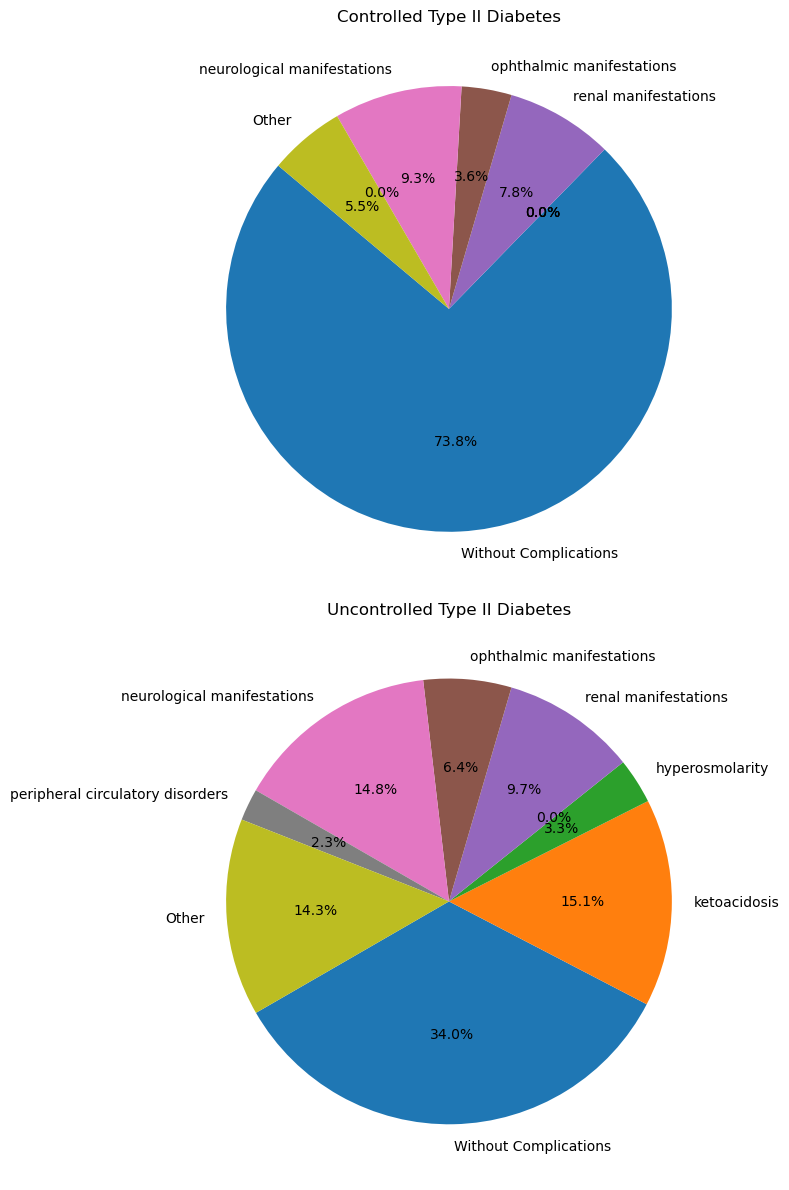

In [44]:

labels1 = list(desc_cat.keys())
sizes1 = [desc_cat[key]['controlled'] for key in labels1]
labels1 = [re.sub('.*with ', '', label) for label in labels1]
labels1[0] = 'Without Complications'
labels1[-2] = 'Other'
sizes1[-2] += sizes1[-1]
labels1 = labels1[:-1]
sizes1 = sizes1[:-1]

# Prepare data for the second pie chart
labels2 = list(desc_cat.keys())
sizes2 = [desc_cat[key]['uncontrolled'] for key in labels2]
labels2 = [re.sub('.*with ', '', label) for label in labels2]
labels2[0] = 'Without Complications'
labels2[-2] = 'Other'
sizes2[-2] += sizes2[-1]
labels2 = labels2[:-1]
sizes2 = sizes2[:-1]

small1 = sum(sizes1) // 100
small2 = sum(sizes2) // 100
for i in range(len(labels1)):
    if sizes1[i] < small1:
        sizes1[-1] += sizes1[i]
        labels1[i] = ''
        sizes1[i] = 0
    if sizes2[i] < small2:
        sizes2[-1] += sizes2[i]
        labels2[i] = ''
        sizes2[i] = 0

# Create the first pie chart
plt.figure(figsize=(8, 12))
plt.subplot(2, 1, 1)
plt.pie(sizes1, labels=labels1, autopct='%1.1f%%', startangle=140)
plt.title('Controlled Type II Diabetes')

# Create the second pie chart
plt.subplot(2, 1, 2)
plt.pie(sizes2, labels=labels2, autopct='%1.1f%%', startangle=210)
plt.title('Uncontrolled Type II Diabetes')

# Display the pie charts
plt.tight_layout()
plt.show()

In [45]:
result = con.execute("""
    SELECT DRUG, COUNT(*) AS count
    FROM (
        SELECT DISTINCT p.HADM_ID,
        CASE
            WHEN p.DRUG LIKE '%Sodium Chloride%' THEN 'Sodium Chloride'
            WHEN p.DRUG LIKE '%Dextrose%' THEN 'Dextrose'
            ELSE p.DRUG
        END AS DRUG
        FROM PRESCRIPTIONS p
        JOIN DIAGNOSES_ICD d ON p.HADM_ID = d.HADM_ID
        WHERE d.ICD9_CODE LIKE '250%'
    ) subquery
    GROUP BY DRUG
    ORDER BY count DESC
    LIMIT 12
""").fetchall()

df = pd.DataFrame(result, columns=['DRUG', 'count'])
df.index += 1
print(df)

                  DRUG  count
1              Insulin  12579
2      Sodium Chloride  11579
3             Dextrose  10503
4        Acetaminophen   9824
5   Potassium Chloride   9350
6              Heparin   9231
7    Magnesium Sulfate   8817
8      Docusate Sodium   8249
9           Furosemide   7680
10                 D5W   7419
11                  NS   7033
12             Aspirin   6996


In [46]:
codes_d = {
    'non_diabetes_diagnoses' : "d.icd9_code NOT LIKE '250%'",
    'all_type_ii_diabetes' : "d.icd9_code LIKE '250%'",
    'controlled_type_ii_diabetes' : "d.icd9_code LIKE '250_0'",
    'uncontrolled_type_ii_diabetes' : "d.icd9_code LIKE '250_2'",
}
a1c = {}
for stat, command in (('Average', 'AVG'), ('Median', 'MEDIAN')):
    a1c[stat] = {}
    for catagory, condition in codes_d.items():
        query = f'''
        WITH hadm_ids_with_a1c AS (
            SELECT DISTINCT l.HADM_ID
            FROM LABEVENTS l
            WHERE l.ITEMID = {a1c_code}
        )
        SELECT {command}(CAST(l.VALUE AS DOUBLE)) AS average_a1c
        FROM LABEVENTS l
        JOIN DIAGNOSES_ICD d ON l.SUBJECT_ID = d.SUBJECT_ID
        JOIN hadm_ids_with_a1c h ON l.HADM_ID = h.HADM_ID
        WHERE l.ITEMID = {a1c_code} AND {condition} AND l.VALUE ~ '^[0-9]+(\.[0-9]+)?$';
        '''
        a1c[stat][catagory] = con.execute(query).fetchone()[0]
for stat, catagories in a1c.items():
    print(f'\n{stat} A1C:')
    for catagory, value in catagories.items():
        print(f'  {catagory} : {value:.2f}')


Average A1C:
  non_diabetes_diagnoses : 6.82
  all_type_ii_diabetes : 8.35
  controlled_type_ii_diabetes : 7.18
  uncontrolled_type_ii_diabetes : 9.35

Median A1C:
  non_diabetes_diagnoses : 6.10
  all_type_ii_diabetes : 7.60
  controlled_type_ii_diabetes : 6.80
  uncontrolled_type_ii_diabetes : 8.70


In [47]:
a1c_code = '50852'
query = f'''
WITH hadm_ids_with_a1c AS (
    SELECT DISTINCT l.HADM_ID
    FROM LABEVENTS l
    WHERE l.ITEMID = {a1c_code}
),
hadm_ids_with_metformin AS (
    SELECT DISTINCT n.HADM_ID
    FROM noteevents_metformin n
    WHERE n.text ILIKE '%metformin%'
),
hadm_ids_without_metformin AS (
    SELECT DISTINCT h.HADM_ID
    FROM hadm_ids_with_a1c h
    LEFT JOIN hadm_ids_with_metformin m ON h.HADM_ID = m.HADM_ID
    WHERE m.HADM_ID IS NULL
)
SELECT 
    'With Metformin' AS category,
    MEDIAN(CAST(l.VALUE AS DOUBLE)) AS average_a1c
FROM LABEVENTS l
JOIN DIAGNOSES_ICD d ON l.SUBJECT_ID = d.SUBJECT_ID
JOIN hadm_ids_with_metformin h ON l.HADM_ID = h.HADM_ID
WHERE l.ITEMID = {a1c_code} AND l.VALUE ~ '^[0-9]+(\.[0-9]+)?$'
AND d.ICD9_CODE LIKE '250_0' -- controlled Type II Diabetes
UNION ALL
SELECT 
    'Without Metformin' AS category,
    MEDIAN(CAST(l.VALUE AS DOUBLE)) AS average_a1c
FROM LABEVENTS l
JOIN DIAGNOSES_ICD d ON l.SUBJECT_ID = d.SUBJECT_ID
JOIN hadm_ids_without_metformin h ON l.HADM_ID = h.HADM_ID
WHERE l.ITEMID = {a1c_code} AND l.VALUE ~ '^[0-9]+(\.[0-9]+)?$'
AND d.ICD9_CODE LIKE '250_0' -- controlled Type II Diabetes
'''
result = con.execute(query).fetchall()
df = pd.DataFrame(result, columns=['category', 'average_a1c'])
df.index = df.index + 1
print(df)

            category  average_a1c
1     With Metformin          6.9
2  Without Metformin          6.7


In [48]:
# Find comorbidities of patients with type II diabetes
result = con.execute("""
    WITH diabetes_patients AS (
        SELECT DISTINCT subject_id
        FROM DIAGNOSES_ICD
        WHERE icd9_code LIKE '250%' AND
              (icd9_code LIKE '%0' OR icd9_code LIKE '%2')
    )
    SELECT d_desc.long_title
    FROM DIAGNOSES_ICD AS d
    JOIN D_ICD_DIAGNOSES AS d_desc
    ON d.icd9_code = d_desc.icd9_code
    WHERE d.subject_id IN (SELECT subject_id FROM diabetes_patients)
      AND d.icd9_code NOT LIKE '250%'  -- Exclude diabetes diagnoses
""").fetch_df()

summary = result.groupby(['LONG_TITLE']).agg(
    count=('LONG_TITLE', 'count')
).reset_index().sort_values(by='count', ascending=False)

summary.columns = ['DIAGNOSIS CATEGORY', 'NUMBER OF PATIENTS']
summary = summary.head(10)
print(summary)

                                     DIAGNOSIS CATEGORY  NUMBER OF PATIENTS
3781                 Unspecified essential hypertension                6694
1019              Congestive heart failure, unspecified                5418
1071  Coronary atherosclerosis of native coronary ar...                4795
434                                 Atrial fibrillation                4248
179                   Acute kidney failure, unspecified                3475
2452               Other and unspecified hyperlipidemia                3444
227                           Acute respiratory failure                2311
3885        Urinary tract infection, site not specified                2156
1881                 Long-term (current) use of insulin                2093
3277                          Pure hypercholesterolemia                2066


In [49]:
codes2 = {
    'h1c_in_range  (not diagnosed)' : "l.VALUE_DOUBLE < 5.7 AND d.icd9_code NOT LIKE '250%'",
    'pre_diabetic  (not diagnosed)' : "l.VALUE_DOUBLE >= 5.7 AND l.VALUE_DOUBLE < 6.5 AND d.icd9_code NOT LIKE '250%'",
    'diabetic      (not diagnosed)' : "l.VALUE_DOUBLE >= 6.5 AND d.icd9_code NOT LIKE '250%'",
    'controlled_type_ii_diabetes' : "d.icd9_code LIKE '250_0'",
    'uncontrolled_type_ii_diabetes' : "d.icd9_code LIKE '250_2'",
}
con.execute("DROP VIEW IF EXISTS LABEVENTS_DOUBLE_VIEW;")
con.execute("""
CREATE VIEW LABEVENTS_DOUBLE_VIEW AS
SELECT
    *,
    TRY_CAST(VALUE AS DOUBLE) AS VALUE_DOUBLE
FROM LABEVENTS
WHERE TRY_CAST(VALUE AS DOUBLE) IS NOT NULL;
""")

by_age = {}
age_groups = [30, 40, 50, 60, 70, 80]
for age in age_groups:
    for category, condition in codes2.items():
        result = con.execute(f"""
            WITH hadm_ids_with_a1c AS (
                SELECT DISTINCT l.HADM_ID
                FROM LABEVENTS_DOUBLE_VIEW l
                WHERE l.ITEMID = {a1c_code}
            )
            SELECT COUNT(DISTINCT d.hadm_id) AS admissions_count
            FROM LABEVENTS_DOUBLE_VIEW l
            JOIN DIAGNOSES_ICD d ON l.HADM_ID = d.HADM_ID
            JOIN ADMISSIONS a ON d.hadm_id = a.hadm_id
            JOIN PATIENTS p ON d.subject_id = p.subject_id
            JOIN hadm_ids_with_a1c h ON l.HADM_ID = h.HADM_ID
            WHERE l.ITEMID = {a1c_code} AND {condition}
            AND (CAST(strftime('%Y', a.admittime) AS INTEGER) - CAST(strftime('%Y', p.dob) AS INTEGER)) BETWEEN {age} AND {age+10};
        """).fetchone()[0]
        by_age.setdefault(f'{age}-{age+10}', {})[category] = result
pd.set_option('display.width', 160)
df = pd.DataFrame.from_dict(by_age, orient='index')
print(df)

       h1c_in_range  (not diagnosed)  pre_diabetic  (not diagnosed)  diabetic      (not diagnosed)  controlled_type_ii_diabetes  uncontrolled_type_ii_diabetes
30-40                             75                             48                             90                           33                              8
40-50                            229                            177                            233                          124                             50
50-60                            388                            460                            483                          391                            101
60-70                            452                            692                            671                          674                             89
70-80                            409                            801                            562                          671                             61
80-90                            307          

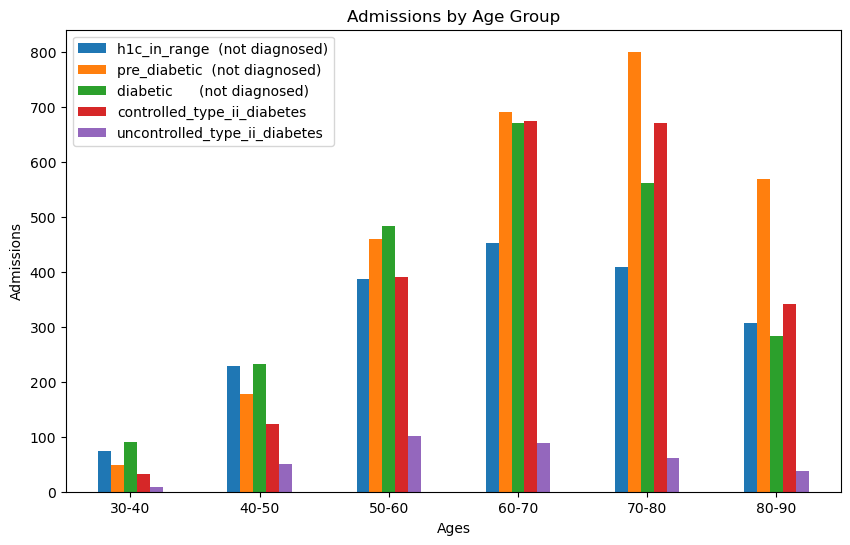

In [50]:
ax = df.plot(kind='bar', figsize=(10, 6))

# Customizing the plot
ax.set_xlabel('Ages')
ax.set_ylabel('Admissions')
ax.set_title('Admissions by Age Group')
plt.xticks(rotation=0)  # Rotate x-axis labels to horizontal

# Show the plot
plt.show()

In [51]:
by_age = {
    'bmi' : {},
    'systolic_bp' : {},
    'diastolic_bp' : {}
}
age_groups = [30, 40, 50, 60, 70, 80]
for age in age_groups:
    for category, condition in codes.items():
        if category.startswith('all'):
            continue
        result = con.execute(f"""
            WITH height_weight AS (
                SELECT 
                    HADM_ID,
                    MAX(CASE WHEN ITEMID = {height} THEN VALUENUM END) AS height,
                    MAX(CASE WHEN ITEMID = {weight} THEN VALUENUM END) AS weight
                FROM chartevents_height_weight_systolic_diastolic
                GROUP BY HADM_ID
            ),
            blood_pressure AS (
                SELECT 
                    HADM_ID,
                    MAX(CASE WHEN ITEMID = {systolic_bp} THEN VALUENUM END) AS systolic_bp,
                    MAX(CASE WHEN ITEMID = {diastolic_bp} THEN VALUENUM END) AS diastolic_bp
                FROM chartevents_height_weight_systolic_diastolic
                GROUP BY HADM_ID
            ),
            combined_data AS (
                SELECT 
                    d.HADM_ID,
                    (h.weight / ((h.height / 39.37) * (h.height / 39.37))) AS BMI,
                    b.systolic_bp,
                    b.diastolic_bp
                FROM DIAGNOSES_ICD d
                JOIN height_weight h ON d.HADM_ID = h.HADM_ID
                JOIN blood_pressure b ON d.HADM_ID = b.HADM_ID
                JOIN PATIENTS p ON d.subject_id = p.subject_id
                JOIN ADMISSIONS a ON d.HADM_ID = a.HADM_ID
                WHERE {condition}
                AND (CAST(strftime('%Y', a.admittime) AS INTEGER) - CAST(strftime('%Y', p.dob) AS INTEGER)) BETWEEN {age} AND {age+10}
            )
            SELECT 
                PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY BMI) AS median_bmi,
                PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY systolic_bp) AS median_systolic_bp,
                PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY diastolic_bp) AS median_diastolic_bp
            FROM combined_data;
        """).fetchone()
        by_age['bmi'].setdefault(f'{age}-{age+10}', {})[category] = result[0]
        by_age['systolic_bp'].setdefault(f'{age}-{age+10}', {})[category] = result[1]
        by_age['diastolic_bp'].setdefault(f'{age}-{age+10}', {})[category] = result[2]
print('Median BMI')
df = pd.DataFrame.from_dict(by_age['bmi'], orient='index')
print(df)
print('\nMedian Systolic BP')
df = pd.DataFrame.from_dict(by_age['systolic_bp'], orient='index')
print(df)
print('\nMedian Diastolic BP')
df = pd.DataFrame.from_dict(by_age['diastolic_bp'], orient='index')
print(df)

Median BMI
       non_diabetes_diagnoses  controlled_type_ii_diabetes  uncontrolled_type_ii_diabetes
30-40               26.828861                    36.641847                      28.625541
40-50               28.381291                    32.413641                      30.971050
50-60               28.714498                    31.875311                      33.576488
60-70               28.595861                    31.033262                      31.866905
70-80               27.661483                    29.177453                      28.831531
80-90               25.951305                    27.264618                      26.891070

Median Systolic BP
       non_diabetes_diagnoses  controlled_type_ii_diabetes  uncontrolled_type_ii_diabetes
30-40                   150.0                        155.0                          157.0
40-50                   149.0                        155.0                          149.0
50-60                   151.0                        154.0           

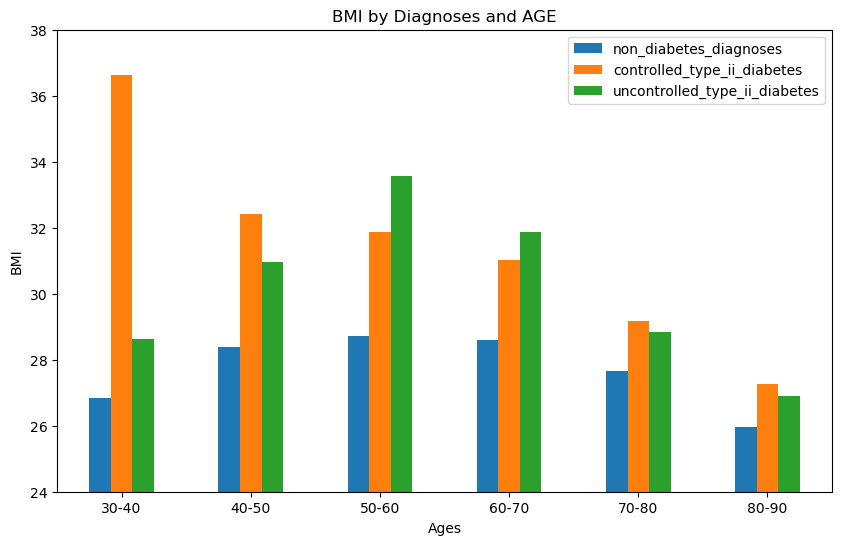

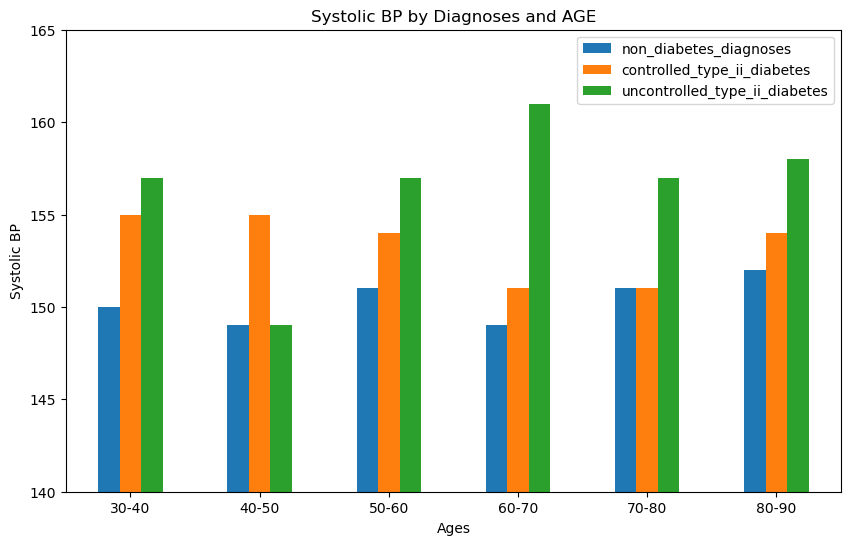

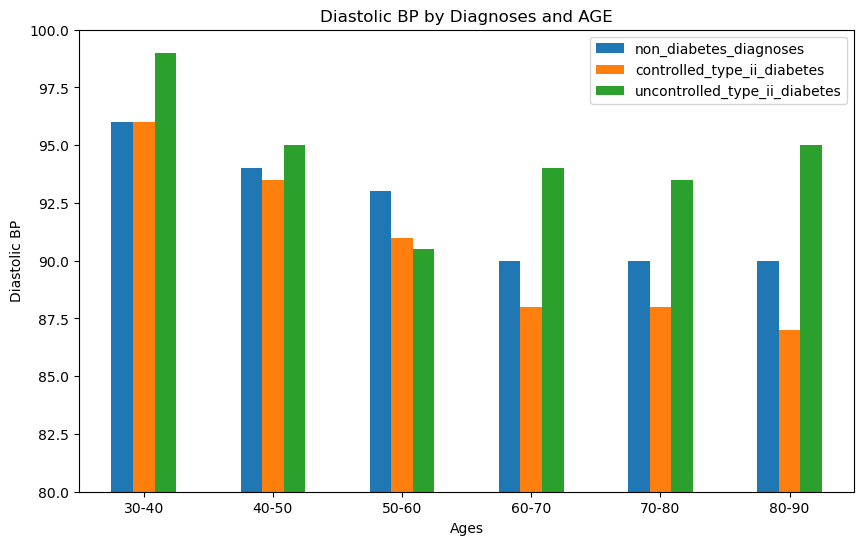

In [52]:
for measurement in by_age:
    df = pd.DataFrame.from_dict(by_age[measurement], orient='index')
    ax = df.plot(kind='bar', figsize=(10, 6))

    if measurement == 'bmi':
        ylabel = 'BMI'
        plt.ylim(24, 38)
    elif measurement == 'systolic_bp':
        ylabel = 'Systolic BP'
        plt.ylim(140, 165)
    else:
        ylabel = 'Diastolic BP'
        plt.ylim(80, 100)

    # Customizing the plot
    ax.set_xlabel('Ages')
    ax.set_ylabel(ylabel)
    ax.set_title(f'{ylabel} by Diagnoses and AGE')
    plt.xticks(rotation=0)  # Rotate x-axis labels to horizontal

    # Show the plot
    plt.show()